In [1]:
#add wget to kernel, but this is the import wget NOT USED
#import sys
#!{sys.executable} -m pip install wget

In [14]:
#to be run using
#
#mamba activate new-lausanne-heat-islands  #From WSL
#
#python -m ipykernel install --user --name lausanne-heat-islands --display-name "Python (lausanne-heat-islands)"
#
#

In [61]:
!make -C .. regression_df

make: Entering directory '/mnt/c/Users/beber/FBK/0_prj/0_UHeatI/invest/published/lausanne-heat-islands'
make: Nothing to be done for 'regression_df'.
make: Leaving directory '/mnt/c/Users/beber/FBK/0_prj/0_UHeatI/invest/published/lausanne-heat-islands'


In [2]:
!wget

wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


In [37]:
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from sklearn import (ensemble, inspection, linear_model, metrics,
                     model_selection, svm)
from sklearn import utils as sk_utils

from lausanne_heat_islands import utils

In [16]:
regression_df_filepath = '../data/interim/regression/regression-df.csv'

In [17]:
regression_df = pd.read_csv(regression_df_filepath, index_col=[0, 1])

In [18]:
def make_dataset(regression_df,
                 features=None,
                 target='tair_station',
                 shuffle=True):
    y = regression_df[target]
    if features is None:
        X = regression_df.drop(target, axis=1)
    else:
        X = regression_df[list(features)]

    if shuffle:
        X, y = sk_utils.shuffle(X, y)

    return X, y

In [19]:
regression_df.head()

lst_0    ndwi_0    lst_200  ndwi_200  \
2018-05-25 BOURG-EN-LAVAUX  26.014134 -0.334515  26.754689 -0.266422   
           BOVDCH           21.650461 -0.456614  21.830704 -0.392005   
           BOVDMR           26.395785 -0.229706  26.079124 -0.269882   
           BOVDSO           21.088022 -0.465147  21.477795 -0.417006   
           MARCELIN         24.975926 -0.355455  25.100744 -0.343064   

                              lst_400  ndwi_400    lst_600  ndwi_600  \
2018-05-25 BOURG-EN-LAVAUX  26.528556 -0.275616  26.043737 -0.260330   
           BOVDCH           22.426036 -0.401703  22.464239 -0.406227   
           BOVDMR           25.949049 -0.262776  25.356981 -0.217986   
           BOVDSO           22.195320 -0.388652  22.970605 -0.376730   
           MARCELIN         24.344891 -0.371353  24.286819 -0.371502   

                              lst_800  ndwi_800  elev  tair_station  
2018-05-25 BOURG-EN-LAVAUX  25.255805 -0.219232   519          21.1  
           BOVDCH           22.308259 -0.396235   680          17.3  
           BOVDMR           24.551374 -0.167194   380          21.2  
           BOVDSO           23.260748 -0.365749   500          19.8  
           MARCELIN         24.394364 -0.367017   436          18.5

After dropping the missing observations, the total number of samples is:

In [20]:
len(regression_df)

88

## Model performance

In [21]:
target = 'tair_station'

model_dict = {
    'lr': linear_model.LinearRegression,
    'svm': svm.SVR,    
    'rf': ensemble.RandomForestRegressor
}

In [38]:
#need to add localy since not in the last release
# STATS
#METRIC_COLUMNS = ['R^2', 'MAE', 'RMSE']

#def compute_model_perf(obs, pred):
#    return [
#        metrics.r2_score(obs, pred),
#        metrics.mean_absolute_error(obs, pred),
#        metrics.mean_squared_error(obs, pred, squared=False)]

# let's add them to utils
#USUALLY DON'T DO THIS is a BAD idea
#import types

#M0 abshttps://stackoverflow.com/questions/972/adding-a-method-to-an-existing-object-instance
#utils.compute_model_perf = compute_model_perf.__get__(utils)
#M1
#foo.sample_method = types.MethodType(sample_method, foo)
#utils.compute_model_perf = types.MethodType(compute_model_perf, utils)





In [40]:
X, y = make_dataset(regression_df, target=target)

model_perf_df = pd.DataFrame(columns=['R^2', 'MAE', 'RMSE'])
for model_label in model_dict:
    model = model_dict[model_label]
    regr = model().fit(X, y)
    y_pred = regr.predict(X)
    model_perf_df.loc[model.__name__] = [metrics.r2_score(y, y_pred),
                                        metrics.mean_absolute_error(y, y_pred),
                                        metrics.mean_squared_error(y, y_pred, squared=False)]


model_perf_df.style.set_caption('Table 1. Model performance with all samples')

,R^2,MAE,RMSE
LinearRegression,0.831891,1.197609,1.508089
SVR,0.014353,2.670680,3.651673
RandomForestRegressor,0.960094,0.589899,0.734769


If all the samples are considered, the random forest regressor achieves the best fit with a coefficient of determination of $R^2 = 0.960$, followed by the $R^2 = 0.832$ achieved by the ordinary linear regression.

### Cross validation

In [41]:
num_repetitions = 20
num_folds = 3

In [42]:
accuracy_df = pd.DataFrame(columns=model_dict.keys(),
                           index=range(num_repetitions))

for i in range(num_repetitions):
    X, y = make_dataset(regression_df, target=target)

    for model_label in model_dict:
        accuracy_df.loc[(i, model_label)] = model_selection.cross_val_score(
            model_dict[model_label](), X, y, cv=num_folds).mean()

# output a Table with nicer row/column labels
pd.DataFrame({
    'Cross validation R^2': accuracy_df.mean()
}).rename(index=lambda model_label: model_dict[model_label].__name__
          ).style.set_caption('Table 2. Cross validation scores')

,Cross validation R^2
LinearRegression,0.745665
SVR,-0.030767
RandomForestRegressor,0.644198


The cross validation suggests that the linear regression is more robust to missing data and also less likely to over-fit the observations than the random forest regressor.

## Feature importance

In [43]:
X, y = make_dataset(regression_df, target=target)

for model_label in model_dict:
    model = model_dict[model_label]
    regr = model().fit(X, y)

    importance_df = pd.DataFrame(
        inspection.permutation_importance(regr, X, y),
        index=regression_df.drop(target, axis=1).columns,
        columns=[f'importances_{param}' for param in ('mean', 'std')])
    print(model)
    print(
        importance_df.sort_values(by='importances_mean',
                                  ascending=False).head(10))
    print()

<class 'sklearn.linear_model._base.LinearRegression'>
          importances_mean  importances_std
ndwi_600         34.245214         2.722487
ndwi_400         19.197177         1.758486
ndwi_800          9.921540         1.182544
lst_400           6.431410         0.841423
lst_800           4.972300         0.523839
lst_600           1.885959         0.203226
ndwi_200          0.957513         0.074569
lst_0             0.534486         0.070350
lst_200           0.194635         0.046995
ndwi_0            0.100645         0.020170

<class 'sklearn.svm._classes.SVR'>
          importances_mean  importances_std
elev          8.059510e-02     3.223143e-02
lst_0         2.079984e-03     2.583669e-04
lst_200       1.960860e-03     2.274274e-04
lst_400       1.809959e-03     2.139295e-04
lst_600       1.713357e-03     2.021454e-04
lst_800       1.699908e-03     1.982223e-04
ndwi_0        3.198545e-07     1.413183e-07
ndwi_400      1.915313e-07     9.871329e-08
ndwi_200      1.875589e-07    

The feature importances change dramatically according to the regression model.

In the case of linear regression, the feature importances can be futher assessed by a F-test of significance:

In [44]:
est = sm.OLS(y, sm.add_constant(X))
est.fit().summary(title='Table 3. OLS regression results')

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Table 3. OLS regression results                        
==============================================================================
Dep. Variable:           tair_station   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     34.19
Date:                Wed, 21 Sep 2022   Prob (F-statistic):           5.61e-25
Time:                        09:31:53   Log-Likelihood:                -161.02
No. Observations:                  88   AIC:                             346.0
Df Residuals:                      76   BIC:                             375.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1760      3.369      0.349      0.728      -5.534       7.886
lst_0          0.4944      0.584      0.846      0.400      -0.669       1.658
ndwi_0        -6.1852      5.127     -1.206      0.231     -16.396       4.026
lst_200       -0.3267      0.885     -0.369      0.713      -2.089       1.435
ndwi_200     -28.5531     15.581     -1.833      0.071     -59.585       2.479
lst_400       -1.9332      1.765     -1.095      0.277      -5.449       1.583
ndwi_400     124.2456     46.749      2.658      0.010      31.138     217.353
lst_600        1.0526      2.963      0.355      0.723      -4.849       6.955
ndwi_600    -156.7220     55.931     -2.802      0.006    -268.119     -45.325
lst_800        1.7306      1.685      1.027      0.308      -1.626       5.087
ndwi_800      85.4412     22.732      3.759      0.000      40.167     130.715
elev          -0.0026      0.003     -0.810      0.420      -0.009       0.004
==============================================================================
Omnibus:                        3.766   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                3.337
Skew:                           0.475   Prob(JB):                        0.189
Kurtosis:                       3.086   Cond. No.                     2.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With a significance level of $p=0.05$, the results of the F-test suggest that the significant variables for the linear regression are the NDWI when spatially averaged over a 800m, 600m and 400m radius (in decreasing order of significance). The following most significant variable is the NDWI spatially averaged over a 200m radius ($p=0.071$) and without spatial averaging ($p=0.231$), and the LST spatially averaged over a 400m radius ($p=0.277$). With a $p=0.420$, the does not appear to be significant in this particular regression.

## Prediction with the chosen model

In [45]:
X, y = make_dataset(regression_df, shuffle=False)

# regr = ensemble.RandomForestRegressor().fit(X, y)
regr = linear_model.LinearRegression().fit(X, y)

y_pred = regr.predict(X)

## Unraveling the error patterns

In [46]:
comparison_df = regression_df.copy()

comparison_df['obs'] = y
comparison_df['pred'] = y_pred
comparison_df['err'] = y_pred - y
# comparison_df['sq_err'] = comparison_df['err']**2

comparison_df['date'] = pd.to_datetime(comparison_df.index.get_level_values(0))
comparison_df['station'] = comparison_df.index.get_level_values(1)

FileNotFoundError: [Errno 2] No such file or directory: '../reports/figures/spatial-regression-pred-obs.pdf'

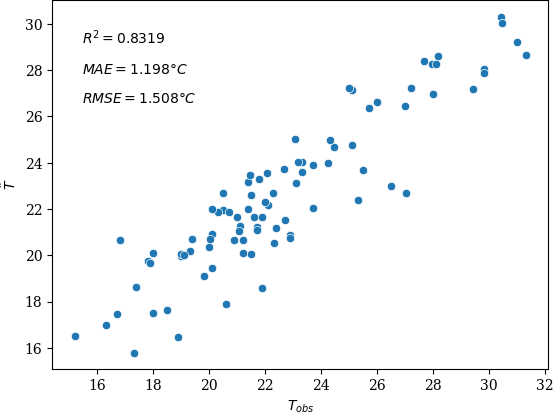

In [47]:
fig = utils.plot_pred_obs(comparison_df)
fig.savefig('../reports/figures/spatial-regression-pred-obs.pdf')

FileNotFoundError: [Errno 2] No such file or directory: '../reports/figures/spatial-regression-errors.pdf'

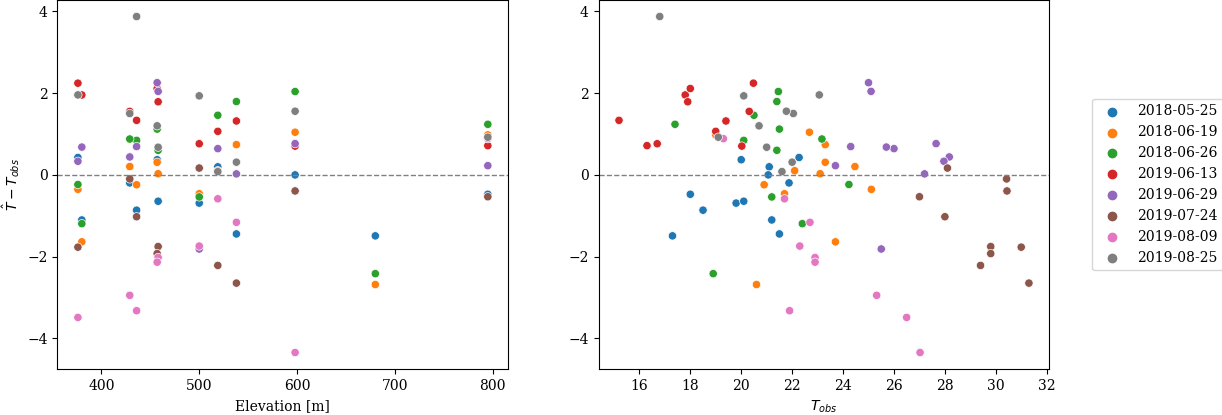

In [48]:
fig = utils.plot_err_elev_obs(comparison_df)
fig.savefig('../reports/figures/spatial-regression-errors.pdf')

### Plotting the maps predicted by the spatial regression

In [64]:
!pwd

/mnt/c/Users/beber/FBK/0_prj/0_UHeatI/invest/published/lausanne-heat-islands/notebooks


In [71]:
!make -C ../. tair_regr_maps

make: Entering directory '/mnt/c/Users/beber/FBK/0_prj/0_UHeatI/invest/published/lausanne-heat-islands'
wget https://data.geo.admin.ch/ch.swisstopo.digitales-hoehenmodell_25/data.zip -O data/raw/dhm200/DHM200.zip
--2022-09-21 11:12:10--  https://data.geo.admin.ch/ch.swisstopo.digitales-hoehenmodell_25/data.zip
Resolving data.geo.admin.ch (data.geo.admin.ch)... 99.86.159.61, 99.86.159.20, 99.86.159.22, ...
Connecting to data.geo.admin.ch (data.geo.admin.ch)|99.86.159.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45069784 (43M) [application/octet-stream]
Saving to: ‘data/raw/dhm200/DHM200.zip’

data/raw/dhm200/DHM 100%[===================>]  42.98M  23.4MB/s    in 1.8s    

2022-09-21 11:12:12 (23.4 MB/s) - ‘data/raw/dhm200/DHM200.zip’ saved [45069784/45069784]

unzip -j data/raw/dhm200/DHM200.zip -d data/raw/dhm200
Archive:  data/raw/dhm200/DHM200.zip
  inflating: data/raw/dhm200/DHM200.asc  
  inflating: data/raw/dhm200/DHM200.xyz  
  inflating: data/raw/

In [73]:
help(utils)

Help on module lausanne_heat_islands.utils in lausanne_heat_islands:

NAME
    lausanne_heat_islands.utils

FUNCTIONS
    plot_T_maps(T_da, station_location_df, num_cols=3, comparison_df=None, err_classes=None, **plot_kws)
    
    plot_comparison_hists(T_diff_da, station_tair_df)
    
    plot_err_elev_obs(comparison_df)
    
    plot_pred_obs(comparison_df)

DATA
    CRS = 'epsg:2056'
    ERR_BOUNDARIES = [-12, -6, -2, 2, 6, 12]
    ERR_CLASSES = [-5, -3, -1, 1, 3, 5]

FILE
    /mnt/c/Users/beber/FBK/0_prj/0_UHeatI/invest/published/lausanne-heat-islands/lausanne_heat_islands/utils.py




In [59]:
tair_regr_filepath = '../data/processed/tair-regr-maps.nc'
station_locations_filepath = '../data/raw/stations/station-locations.csv'

In [60]:
T_regr_da = xr.open_dataarray(tair_regr_filepath)
station_location_df = pd.read_csv(station_locations_filepath, index_col='stn')

FileNotFoundError: [Errno 2] No such file or directory: b'/mnt/c/Users/beber/FBK/0_prj/0_UHeatI/invest/published/lausanne-heat-islands/data/processed/tair-regr-maps.nc'

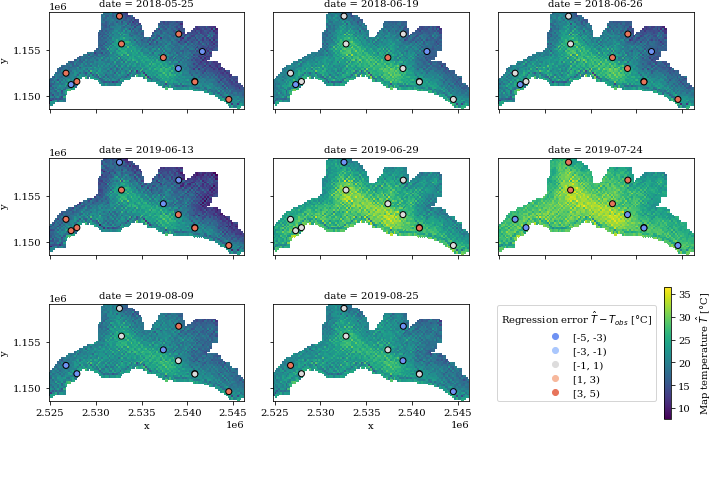

In [21]:
g = utils.plot_T_maps(T_regr_da,
                      station_location_df,
                      comparison_df=comparison_df)
g.fig.savefig('../reports/figures/spatial-regression-maps.png')